In [12]:
import os
import torch
import optuna
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve
from STGCN import SpatialTemporalGraphConvNetwork
from tqdm import tqdm

In [2]:
class MyDataset(Dataset):
    def __init__(self, root_dir, augment_prob=0.5):
        self.augment_prob = augment_prob
        self.data = []
        for i in range(len(os.listdir(root_dir))):
            path = os.path.join(root_dir, "class_" + str(i))
            class_data = os.listdir(path)
            for sample_path in class_data:
                sample_full_path = os.path.join(path, sample_path)
                sample = np.load(sample_full_path)
                self.data.append((sample, i))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample, label = self.data[index]
        if np.random.rand() < self.augment_prob:
            sample = self.augmentation_flip(sample)

        # [T, N, C] -> [C, T, N]
        sample = np.transpose(sample, (2, 0, 1))
        sample = torch.from_numpy(sample)
        y = torch.tensor(label, dtype=torch.long)

        return sample, y

    @staticmethod
    def augmentation_flip(sample):
        # sample shape is [T, N, C]
        sample[:, :, 0] = 1 - sample[:, :, 0]
        return sample

In [3]:
def sep_data(dataset, batch_size):
    train_data, val_data, test_data = random_split(dataset, [0.8, 0.15, 0.05])
    
    val_data.augment_prob = 0
    test_data.augment_prob = 0
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_data, batch_size=2, shuffle=False, drop_last=False)
    test_dataloader = DataLoader(test_data, batch_size=2, shuffle=False, drop_last=False)

    return train_dataloader, val_dataloader, test_dataloader


dataset = MyDataset(root_dir="dataset")
batch_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader, val_dataloader, test_dataloader = sep_data(dataset, batch_size)

print(f'Train samples: {len(train_dataloader) * batch_size}')
print(f'Val samples: {len(val_dataloader) * 2}')
print(f'Test samples: {len(test_dataloader) * 2}')
print(f'Device: {device}')

Train samples: 256
Val samples: 48
Test samples: 16
Device: cuda


In [4]:
def train_stgcn(model, loss_instance, data_loader, optimizer, epoch, epochs, verbose=True, device=device):
    model.to(device)
    model.train()
    total_loss = 0.0

    if verbose:
        data_loader = tqdm(data_loader)
    
    for batch in data_loader:
        data, label = batch
        data, label = data.to(device), label.to(device)

        logits = model(data)

        optimizer.zero_grad()
        loss = loss_instance(logits, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if verbose:
        print(f'Current loss: {total_loss:.4f}. Current epoch: {epoch}/{epochs}')
    
    return total_loss

def eval_stgcn(model, data_loader, device=device):
    model.to(device)
    model.eval()
    results = {}
    true_predict = 0
    total_predict = 0
    with torch.no_grad():
        for item in data_loader:
            data, label = item
            data, label = data.to(device), label.to(device)
            logits = model(data)

            true_predict += (torch.argmax(logits, dim=1) == label).sum().item()
            total_predict += label.size(0)

        accuracy = true_predict / total_predict

    results['accuracy%'] = accuracy * 100
    results['logits'] = logits
    
    return results

In [5]:
def train_model(model=None, loss_instance=None, optimizer=None, train_dataloader=None, val_dataloader=None, epochs=25, save=False, save_file_name='default', verbose=True, device=device):
    results = {'loss_history': [],
    'train_acc_history':[],
    'val_acc_history': []}

    if not(model and loss_instance and optimizer and train_dataloader and val_dataloader):
        print(f'You should pass everything!')
        return None
    
    for epoch in range(epochs):
        train_loss = train_stgcn(model, loss_instance, train_dataloader, optimizer, epoch, epochs, verbose, device)
        train_results = eval_stgcn(model, train_dataloader, device)
        val_results = eval_stgcn(model, val_dataloader, device)
        results['loss_history'].append(train_loss)
        results['train_acc_history'].append(train_results['accuracy%'])
        results['val_acc_history'].append(val_results['accuracy%'])

        if save:
            torch.save({'model_params': model.state_dict(),
               'results': results}, save_file_name)

    return model, results

In [6]:
epochs = 250
model = SpatialTemporalGraphConvNetwork(2, 3, 21, device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_instance = CrossEntropyLoss()

loss_history = []
train_acc_history = []

if 'baseline.pth' in os.listdir():
    answr = int(input(f'wanna load baseline model?\n0 - No\n1 - Yes\n'))

if not(answr):
    model, results = train_model(model=model,
                loss_instance=loss_instance,
                optimizer=optimizer,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                epochs=epochs,
                save=int(input(f'wanna save new baseline model?\n0 - No\n1 - Yes\n')),
                save_file_name='baseline.pth',
                device=device)
else:
    baseline_dict = torch.load('baseline.pth', map_location='cpu', weights_only=False)
    model.load_state_dict(baseline_dict['model_params'])
    results = baseline_dict['results']
    
loss_history, train_acc_history, val_acc_history = results['loss_history'], results['train_acc_history'], results['val_acc_history']

print(f'Baseline accuracies:\n')
print(f'accuracy on val dataset: {eval_stgcn(model, val_dataloader, device)['accuracy%']:.0f}%')
print(f'accuracy on train dataset: {eval_stgcn(model, train_dataloader, device)['accuracy%']:.0f}%')

wanna load baseline model?
0 - No
1 - Yes
 1


Baseline accuracies:

accuracy on val dataset: 85%
accuracy on train dataset: 92%


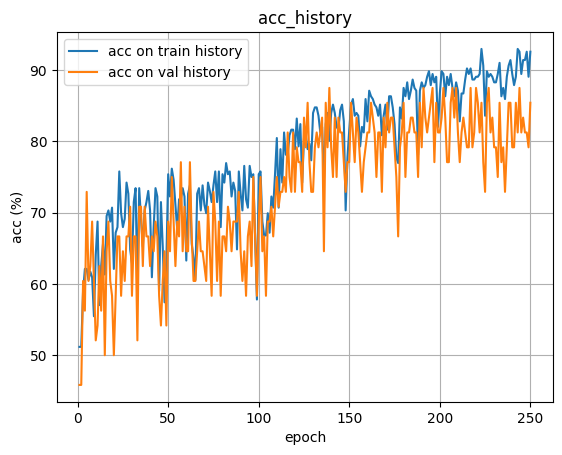

In [7]:
def plot_history(plot_title, ylabel, xlabel, arg_dict):
    for key, value in arg_dict.items():
        plt.plot(np.arange(1, epochs + 1), value, label=key)
    plt.title(plot_title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.grid()
    plt.show()

arg_dict = {'acc on train history': train_acc_history,
            'acc on val history': val_acc_history}

plot_history('acc_history', 'acc (%)', 'epoch', arg_dict)

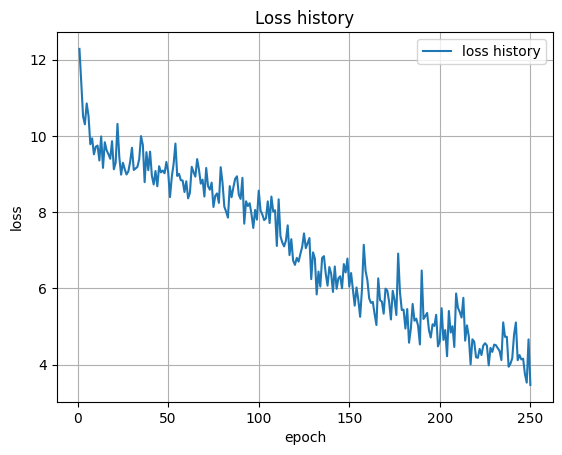

In [8]:
arg_dict = {'loss history': loss_history}

plot_history('Loss history', 'loss', 'epoch', arg_dict)

In [9]:
summary(model, input_size=(3, 30, 21))

Layer (type:depth-idx)                   Param #
├─STGCNBlock: 1-1                        --
|    └─GraphConv: 2-1                    96
|    └─Conv2d: 2-2                       9,248
|    └─ReLU: 2-3                         --
|    └─BatchNorm2d: 2-4                  64
├─STGCNBlock: 1-2                        --
|    └─GraphConv: 2-5                    2,048
|    └─Conv2d: 2-6                       36,928
|    └─ReLU: 2-7                         --
|    └─BatchNorm2d: 2-8                  128
├─STGCNBlock: 1-3                        --
|    └─GraphConv: 2-9                    8,192
|    └─Conv2d: 2-10                      147,584
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 256
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            258
Total params: 204,802
Trainable params: 204,802
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─STGCNBlock: 1-1                        --
|    └─GraphConv: 2-1                    96
|    └─Conv2d: 2-2                       9,248
|    └─ReLU: 2-3                         --
|    └─BatchNorm2d: 2-4                  64
├─STGCNBlock: 1-2                        --
|    └─GraphConv: 2-5                    2,048
|    └─Conv2d: 2-6                       36,928
|    └─ReLU: 2-7                         --
|    └─BatchNorm2d: 2-8                  128
├─STGCNBlock: 1-3                        --
|    └─GraphConv: 2-9                    8,192
|    └─Conv2d: 2-10                      147,584
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 256
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            258
Total params: 204,802
Trainable params: 204,802
Non-trainable params: 0

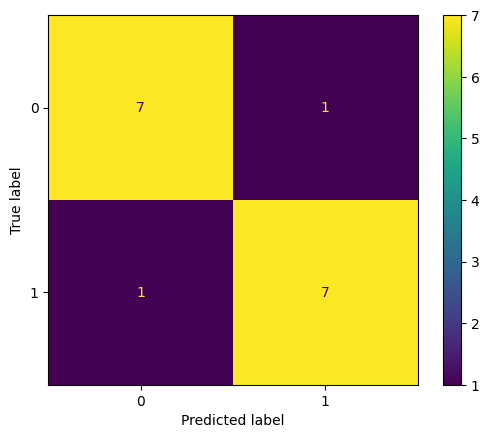

In [10]:
def print_confusion_matrix(model, test_dataloader):
    model = model.eval()
    y_pred_ = []
    label_ = []
    with torch.no_grad():
        for item in test_dataloader:
            data, label = item
            data, label = data.to(device), label.to(device)
            y_pred_ += list(torch.argmax(model(data), dim=1).cpu())
            label_ += list(label.cpu())

    cm = confusion_matrix(label_, y_pred_)
    ConfusionMatrixDisplay(cm).plot()

print_confusion_matrix(model, test_dataloader)

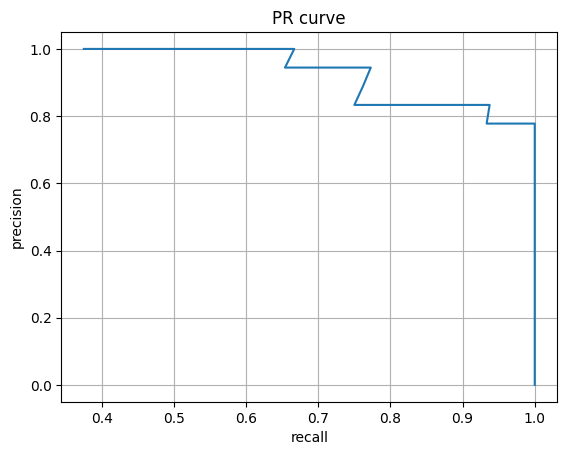

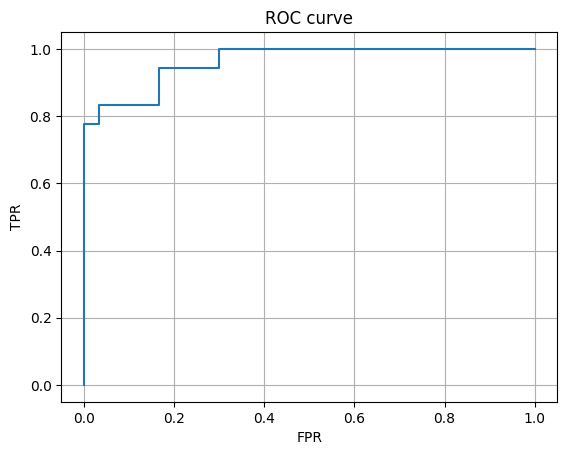

In [17]:
def get_metrics(model, dataloader, device=device):
    model.to(device)
    
    y_real = []
    y_prob = []
    metrics = {}
    with torch.no_grad():
        for data, y in dataloader:
            data, y = data.to(device), y.to(device)
            logits = model(data)
            softmax = torch.nn.Softmax(dim=1)
            probs = softmax(logits)
            y_real += list(y.cpu())
            y_prob += list(probs[:, 1].cpu())

    metrics['precision_recall_curve'] = precision_recall_curve(y_real, y_prob)
    metrics['roc_curve'] = roc_curve(y_real, y_prob)
    
    return metrics

metrics = get_metrics(model, val_dataloader)

precision_history, recall_history, tresholds = metrics['precision_recall_curve']
FPR, TPR, thresholds_ = metrics['roc_curve']

plt.plot(precision_history, recall_history)
plt.title('PR curve')
plt.ylabel('precision')
plt.xlabel('recall')
plt.grid()
plt.show()

plt.plot(FPR, TPR, label='ROC curve')
plt.title('ROC curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid()
plt.show()

In [1]:
# def objective(trial):
#     params = dict(
#         optimizer_lr=trial.suggest_float("optimizer_lr", 1e-4, 1e-2, log=True),
#         batch_size=trial.suggest_int("batch_size", 4, 32)
#     )

#     epochs = 50
#     model = SpatialTimeGraphConvNetwork(2, 3, 21, device=device)
#     loss_instance = CrossEntropyLoss()
#     optimizer = torch.optim.AdamW(params=model.parameters(), lr=params['optimizer_lr'])
#     batch_size = params['batch_size']

#     train_dataloader, val_dataloader, test_dataloader = sep_data(dataset, batch_size)

#     model, _ = train_model(model=model,
#                 loss_instance=loss_instance,
#                 optimizer=optimizer,
#                 train_dataloader=train_dataloader,
#                 val_dataloader=val_dataloader,
#                 epochs=epochs,
#                 save=False,
#                 save_file_name='default.pth',
#                 verbose=False,
#                 device=device)

#     return eval_stgcn(model=model, data_loader=val_dataloader, device=device) 

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)
# model_best_params = study.best_params